In [1]:
import os
import sys

isColab = "google.colab" in sys.modules

if isColab:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True)

    student_colab_path = ("/content/drive/MyDrive"
        + "/Colab Notebooks")
    sys.path.append(student_colab_path)

Mounted at /content/drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
import numpy as np
import os
import json
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from tensorflow.keras.layers import Dense, Rescaling

In [4]:
data_folder_path = "/content/drive/MyDrive/Colab Notebooks/heridal_keras_retinanet_voc"
images_path = data_folder_path + "/JPEGImages"
annotations_path = data_folder_path + "/Annotations/JSON"
ImageSets = data_folder_path + "/ImageSets/Main"

In [5]:
def xml_to_json(xml_folder, json_folder):
    os.makedirs(json_folder, exist_ok=True)

    for xml_file in os.listdir(xml_folder):
        if xml_file.endswith('.xml'):
            xml_path = os.path.join(xml_folder, xml_file)
            json_path = os.path.join(json_folder, xml_file.replace('.xml', '.json'))

            tree = ET.parse(xml_path)
            root = tree.getroot()

            data_dict = {
                'folder': root.find('folder').text if root.find('folder') is not None else 'Unknown',
                'filename': root.find('filename').text if root.find('filename') is not None else 'Unknown',
                'size': {
                    'width': int(root.find('size/width').text) if root.find('size/width') is not None else 0,
                    'height': int(root.find('size/height').text) if root.find('size/height') is not None else 0,
                    'depth': int(root.find('size/depth').text) if root.find('size/depth') is not None else 0,
                },
                'objects': []
            }

            for obj in root.findall('object'):
                bbox = obj.find('bndbox')
                data_dict['objects'].append({
                    'name': obj.find('name').text if obj.find('name') is not None else 'Unknown',
                    'pose': obj.find('pose').text if obj.find('pose') is not None else 'Unspecified',
                    'truncated': int(obj.find('truncated').text) if obj.find('truncated') is not None else 0,
                    'difficult': int(obj.find('difficult').text) if obj.find('difficult') is not None else 0,
                    'bbox': {
                        'xmin': int(bbox.find('xmin').text) if bbox.find('xmin') is not None else 0,
                        'ymin': int(bbox.find('ymin').text) if bbox.find('ymin') is not None else 0,
                        'xmax': int(bbox.find('xmax').text) if bbox.find('xmax') is not None else 0,
                        'ymax': int(bbox.find('ymax').text) if bbox.find('ymax') is not None else 0,
                    }
                })

            with open(json_path, 'w') as json_file:
                json.dump(data_dict, json_file, indent=4)

In [ ]:
#only run if json files don't exist yet
xml_folder = data_folder_path + "/Annotations"
json_folder = annotations_path
xml_to_json(xml_folder, json_folder)

In [6]:
def parse_json(json_string):
    data = json.loads(json_string.decode('utf-8'))
    if 'objects' not in data or not data['objects']:
        return np.zeros((0, 4), dtype=np.float32), np.int32(data['size']['width']), np.int32(data['size']['height'])
    bounding_boxes = np.array([
        [np.int32(obj['bbox']['xmin']), np.int32(obj['bbox']['ymin']),
         np.int32(obj['bbox']['xmax']), np.int32(obj['bbox']['ymax'])]
        for obj in data['objects'] if obj['name'] == 'person'
    ], dtype=np.float32)
    original_width = np.int32(data['size']['width'])
    original_height = np.int32(data['size']['height'])
    return bounding_boxes, original_width, original_height

def load_json(annotation_path):
    json_string = tf.io.read_file(annotation_path)
    bounding_boxes, original_width, original_height = tf.numpy_function(
        parse_json, [json_string], [tf.float32, tf.int32, tf.int32]
    )
    bounding_boxes.set_shape([None, 4])
    original_width.set_shape([])
    original_height.set_shape([])
    return bounding_boxes, original_width, original_height

In [7]:
IMAGE_SIZE = 256
PATCH_SIZE = 16
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
PROJECTION_DIM = 64

In [8]:
def scale_bounding_boxes(bounding_boxes, original_width, original_height, new_width, new_height, pad_w, pad_h):
  if tf.size(bounding_boxes) == 0:
    return tf.zeros((0, 4), dtype=tf.float32)

  original_width = tf.cast(original_width, tf.float32)
  original_height = tf.cast(original_height, tf.float32)
  new_width = tf.cast(new_width, tf.float32)
  new_height = tf.cast(new_height, tf.float32)
  pad_w = tf.cast(pad_w[0], tf.float32)
  pad_h = tf.cast(pad_h[0], tf.float32)

  scale_x = new_width / original_width
  scale_y = new_height / original_height

  xmin_scaled = bounding_boxes[:, 0] * scale_x + pad_w
  ymin_scaled = bounding_boxes[:, 1] * scale_y + pad_h
  xmax_scaled = bounding_boxes[:, 2] * scale_x + pad_w
  ymax_scaled = bounding_boxes[:, 3] * scale_y + pad_h

  bounding_boxes_scaled = tf.stack([xmin_scaled, ymin_scaled, xmax_scaled, ymax_scaled], axis=1)

  return bounding_boxes_scaled

In [9]:
def compute_overlap_counts(bboxes, image_size, patch_size):
    num_patches_side = image_size // patch_size
    patch_indices = tf.range(0, image_size, patch_size)
    start_indices = tf.cast(tf.stack(tf.meshgrid(patch_indices, patch_indices, indexing='ij'), axis=-1), tf.float32)
    end_indices = start_indices + patch_size

    overlap_counts = tf.zeros((num_patches_side, num_patches_side), dtype=tf.int32)

    for bbox in bboxes:
        xmin, ymin, xmax, ymax = bbox[0], bbox[1], bbox[2], bbox[3]
        overlaps_x = tf.logical_and(start_indices[..., 1] < xmax, start_indices[..., 1] + patch_size > xmin)
        overlaps_y = tf.logical_and(start_indices[..., 0] < ymax, start_indices[..., 0] + patch_size > ymin)
        overlaps = tf.logical_and(overlaps_x, overlaps_y)

        overlap_counts += tf.cast(overlaps, tf.int32)

    return tf.expand_dims(overlap_counts, -1)

In [10]:
def preprocess_image(image_path, annotation_path):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)

  original_shape = tf.cast(tf.shape(image)[:2], tf.float32)
  ratio = IMAGE_SIZE / tf.reduce_max(original_shape)
  new_shape = tf.round(original_shape * ratio)

  image = tf.image.resize(image, tf.cast(new_shape, tf.int32))

  pad_w = (IMAGE_SIZE - new_shape[1]) / 2
  pad_h = (IMAGE_SIZE - new_shape[0]) / 2
  pad_w = [pad_w, IMAGE_SIZE - new_shape[1] - pad_w]
  pad_h = [pad_h, IMAGE_SIZE - new_shape[0] - pad_h]

  image = tf.pad(image, [[int(pad_h[0]), int(pad_h[1])], [int(pad_w[0]), int(pad_w[1])], [0, 0]], constant_values=0)
  image = Rescaling(1./255)(image)

  patches = tf.image.extract_patches(
      images=tf.expand_dims(image, 0),
      sizes=[1, PATCH_SIZE, PATCH_SIZE, 1],
      strides=[1, PATCH_SIZE, PATCH_SIZE, 1],
      rates=[1, 1, 1, 1],
      padding='VALID'
  )
  patches = tf.reshape(patches, [-1, PATCH_SIZE * PATCH_SIZE * 3])

  bounding_boxes, original_width, original_height = load_json(annotation_path)
  bounding_boxes_scaled = scale_bounding_boxes(
      bounding_boxes, original_width, original_height,
      new_shape[1], new_shape[0], pad_w, pad_h
  )

  overlap_counts = compute_overlap_counts(bounding_boxes_scaled, IMAGE_SIZE, PATCH_SIZE)

  return patches, overlap_counts, bounding_boxes_scaled

In [11]:
def file_exists(file_path):
    return tf.io.gfile.exists(file_path.numpy().decode())

def create_filtered_dataset(images_path, annotations_path, subset_prefix):
    image_files = tf.data.Dataset.list_files(os.path.join(images_path, subset_prefix + '_*.jpg'))

    def filter_func(image_file):
        annotation_file = tf.strings.regex_replace(image_file, 'JPEGImages', 'Annotations')
        annotation_file = tf.strings.regex_replace(annotation_file, '\.jpg', '.xml')
        return tf.py_function(file_exists, [annotation_file], Tout=tf.bool)

    filtered_image_dataset = image_files.filter(filter_func)

    def load_and_preprocess_image(image_file):
        annotation_file = tf.strings.regex_replace(image_file, 'JPEGImages', 'Annotations/JSON')
        annotation_file = tf.strings.regex_replace(annotation_file, '\.jpg', '.json')
        return preprocess_image(image_file, annotation_file)

    dataset = filtered_image_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

In [12]:
train_dataset = create_filtered_dataset(images_path, annotations_path, 'train')
test_dataset = create_filtered_dataset(images_path, annotations_path, 'test')

for patches, overlap_counts, bboxes in train_dataset.take(1):
    print('Train patches shape:', patches.shape)
    print('Train bounding boxes:', bboxes)
    print('Train overlap counts shape:', overlap_counts.shape)
    print('Train sample overlap counts:', overlap_counts.numpy().flatten()[:256])

for patches, overlap_counts, bboxes in test_dataset.take(1):
    print('Test patches shape:', patches.shape)
    print('Test bounding boxes:', bboxes)
    print('Test overlap counts shape:', overlap_counts.shape)
    print('Test sample overlap counts:', overlap_counts.numpy().flatten()[:256])

Train patches shape: (256, 768)
Train bounding boxes: tf.Tensor([], shape=(0, 4), dtype=float32)
Train overlap counts shape: (16, 16, 1)
Train sample overlap counts: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Test patches shape: (256, 768)
Test bounding boxes: tf.Tensor(
[[113.920006 193.664    118.52801  197.95201 ]
 [151.87201  195.00801  154.688    199.296   ]], shape=(2, 4), dtype=float32)
Test overlap counts shape: (16, 16, 1)
Test sample overlap counts: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Bounding Box: [179.20001220703125, 134.2080078125, 182.84800720214844, 137.4080047607422]
Bounding Box: [177.47201538085938, 131.26400756835938, 181.1840057373047, 134.39999389648438]
Bounding Box: [170.5600128173828, 120.83200073242188, 173.50401306152344, 124.60800170898438]
Bounding Box: [21.760000228881836, 71.42400360107422, 25.920001983642578, 75.71200561523438]
Bounding Box: [24.064001083374023, 68.54400634765625, 27.264001846313477, 72.06400299072266]


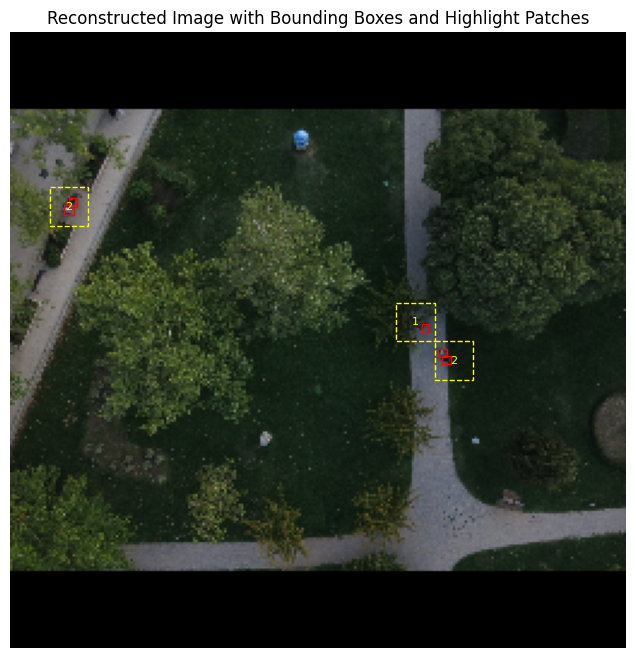

In [13]:
def display_image_with_bboxes(image_patches, overlap_counts, bbox_data, num_patches_side):
    patches_reshaped = tf.reshape(image_patches, [num_patches_side, num_patches_side, PATCH_SIZE, PATCH_SIZE, 3])
    patches_transposed = tf.transpose(patches_reshaped, [0, 2, 1, 3, 4])
    image_reconstructed = tf.reshape(patches_transposed, [IMAGE_SIZE, IMAGE_SIZE, 3])

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image_reconstructed)

    for bbox in bbox_data:
        y_min = bbox[1]
        x_min = bbox[0]
        y_max = bbox[3]
        x_max = bbox[2]
        print(f"Bounding Box: [{x_min}, {y_min}, {x_max}, {y_max}]")

        width = x_max - x_min
        height = y_max - y_min

        rect = mpatches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    for i in range(num_patches_side):
        for j in range(num_patches_side):
            if overlap_counts[i, j, 0] > 0:
                patch_x = j * PATCH_SIZE
                patch_y = i * PATCH_SIZE
                rect = mpatches.Rectangle((patch_x, patch_y), PATCH_SIZE, PATCH_SIZE, linewidth=1, edgecolor='yellow', facecolor='none', linestyle='--')
                ax.add_patch(rect)
                ax.text(patch_x + PATCH_SIZE / 2, patch_y + PATCH_SIZE / 2, str(overlap_counts[i, j, 0]),
                        color='yellow', ha='center', va='center', fontsize=8)

    plt.title("Reconstructed Image with Bounding Boxes and Highlight Patches")
    plt.axis('off')
    plt.show()

for image_patches, overlap_counts, bbox_data in train_dataset.take(1):
    num_patches_side = IMAGE_SIZE // PATCH_SIZE
    display_image_with_bboxes(image_patches.numpy(), overlap_counts.numpy(), bbox_data.numpy(), num_patches_side)